In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.stats import wilcoxon, ranksums
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from scipy.stats import wilcoxon
%matplotlib notebook

# Datos

In [2]:
ORIGEN =  pd.read_csv(
    "/src/data/procesados/filtered/pvalue005.csv", 
    encoding='utf-8',
    index_col=0,
    sep ="\t",
    decimal=",",
    quotechar='"'
    )

In [3]:
datos_rankcalculado =  pd.read_csv(
    "/src/data/procesados/wilcoxon_signed/wicoxvalues.csv", 
    encoding='utf-8',
    index_col=[0,1],
    sep ="\t",
    decimal=",",
    quotechar='"'
    )

In [4]:
datos_prueba=frame = pd.DataFrame(data=np.array([[495,495,490,500],
                                                 [400,400,300,500],
                                                 [310,310,300,331],
                                                 [250,250,220,220],
                                                 [90,90,100,190],
                                                 [80,80,90,90],
                                                 [55,55,56,100],
                                                 [27,27,35,35],
                                                 [18,18,20,20],
                                                 [5,5,1,22]
                                                ]), index=['dato1','dato2','dato3','dato4','dato5','dato6','dato7','dato8','dato9','dato10'], columns=['Población 1','Población 2','Población 3','Población 4'])

# Funciones

In [5]:
def smallest_vocabulary(origin, city1, city2):
    city1_frame = origin[[city1]]
    city1_frame = city1_frame.loc[(city1_frame != 0).all(1)]
    city1_len = len(city1_frame)
    city2_frame = origin[[city2]]
    city2_frame = city2_frame.loc[(city2_frame != 0).all(1)]
    city2_len = len(city2_frame)
    words_to_drop = []
    if city1_len < city2_len:
        words_to_drop = origin.index.difference(city1_frame.index)
        proportion = city1_len/city2_len
    if city1_len > city2_len:
        words_to_drop = origin.index.difference(city2_frame.index)
        proportion = city2_len/city1_len
    smallest=intersection = origin[[city1,city2]].drop(labels=words_to_drop)
    #print(intersection.loc["guindando","Bogotá"])
    vocabulary_size =  pd.DataFrame(smallest.sum(), columns=["#VocabularySize#"]).transpose()
    smallest=pd.concat([vocabulary_size, smallest])
    smallest=smallest.iloc[0:]/smallest.iloc[0]
    smallest.drop(labels="#VocabularySize#", inplace=True)
    #print("A>>>>>>>>>>>>>>>>>>>>{}".format(city1_len))
    #print("B>>>>>>>>>>>>>>>>>>>>{}".format(city2_len))
    #print("Proportion>>>>>>>>>>>{}".format(proportion))
    return(city1_len,city2_len,proportion,smallest)

In [6]:
def graph_wilcox(origin, city1, city2, small=True, labelpoints=False,dotsize=1):
    
    if small == True:
        dialects = smallest_vocabulary(origin, city1, city2)
    else:
        dialects = origin[[city1, city2]]
    
    plt.close('all')
    

    
    
    # Grafica de distribución ZIPF
    dialectA = dialects[city1]*10e7
    dialectB = dialects[city2]*10e7
    ranka = dialectA.rank(method="average", ascending=False)
    rankb = dialectB.rank(method="average", ascending=False)
    substraction = (dialectA-dialectB)
    sign = np.sign(substraction)
    rank = abs(substraction).rank(method="average")
    signedrank = sign*rank
    x = np.array(range(1,dialectA.shape[0]+1))
    x2 = np.array(x*sign)
    plt.clf
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(x , dialectA, c="blue", s=dotsize, edgecolors='none', label=city1)
    ax.scatter(-x ,  dialectB, c="red", s=dotsize, edgecolors='none', label=city2)
    ax.scatter (signedrank, substraction,  c="green", s=dotsize*10, edgecolors='none', label="Resta")
    print(np.array(x2))
    #ax.set_yscale('log')
    #ax.set_xscale('symlog')
    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Ranking')
    ax.set_title('Distribución de valores pareados \n {}-{}'.format(city1, city2))
    ax.legend(markerscale=2, loc='upper right', fontsize=12 )
    ax.grid(True)
    ax.autoscale(enable=True, axis='both', tight=True)
    if labelpoints==True:
        labelpos = list(dialectA.index.values)
        labelcero = list([' '])
        labels = labelcero+labelpos
        tickposition = np.array(range(0,x.max()+1))
        ax.set_yticks(tickposition)
        ax.set_yticklabels(labels, fontsize=12)
    plt.savefig('/src/data/procesados/graphics/distribucion_{}-{}.pdf'.format(city1.replace(' ', ''), city2.replace(' ', '')))
    
        
    
    # Grafico de wilcoxon
    T, pvalue = wilcoxon(dialects[city1],dialects[city2])
    resta = (dialects[city1]-dialects[city2])
    resta = resta.loc[resta != 0]
    n = resta.shape[0]
    s = n*(n+1)/2
    sign = np.sign(resta)
    rank = (abs(resta)).rank(method="average")
    signedrank = sign*rank
    wilcox = signedrank.sum()
 
    if n == 0:
        rankcorr = n
        x = np.array([0,0])
        signedrank = np.array([0,0])
        t1 = np.array([0,0])
        t2 = np.array([0,0])
        t=0
        z=0
    else:
        rankcorr = wilcox/s
        t1 = abs(signedrank.loc[signedrank > 0].sum())
        t2 = abs(signedrank.loc[signedrank < 0].sum())
        t = min(t1,t2)
        z = abs(t-(n*(n+1)/4))/(n*(n+1)*(2*n+1)/(24))**(1/2)
        x = np.array(range(0,n))
        
    plt.clf
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(signedrank, x , c="green", s=dotsize, edgecolors='none', label="Resta")
    ax.plot([rankcorr,rankcorr],[x.min(),x.max()],  c="black",  linewidth=rankcorr*10,  label="Tensión")
    ax.legend(markerscale=2)
    ax.set_xlabel('Rango con signos')
    ax.set_ylabel('Características')
    ax.set_title('Distribución restas rankeadas con signo  \n{}-{}'.format(city1, city2))
    if labelpoints==True:
        labelpos = list(dialectA.index.values)
        labelcero = list([' '])
        labels = labelpos
        tickposition = np.array(range(0,x.max()+1))
        ax.set_yticks(tickposition)
        ax.set_yticklabels(labels, fontsize=12)
    ax.set_yscale('log')
    ax.set_xscale('symlog')
    plt.savefig('/src/data/procesados/graphics/wilcoxon_{}-{}.pdf'.format(city1.replace(' ', ''), city2.replace(' ', '')))

    
    # Grafica de tensión 
    dialectA = dialects[city1].rank(method="average", ascending=False)
    dialectB = dialects[city2].rank(method="average", ascending=False)
    ranksubtraction = dialectA-dialectB    
    x = np.array(range(1,dialectA.shape[0]+1))
    plt.clf
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(x , dialectA, c="blue", s=dotsize, edgecolors='none', label=city1)
    ax.scatter(-x , dialectB, c="red", s=dotsize, edgecolors='none', label=city2)
    ax.scatter(ranksubtraction, x , c="green", s=dotsize, edgecolors='none', label="Resta")
    ax.set_xlabel('Características')
    ax.set_ylabel('Ranking de características')
    ax.legend(markerscale=2, loc='lower right', fontsize=12 )
    ax.autoscale(enable=True, axis='both', tight=True)
    ax.set_title('Distribución de rankings  \n{}-{}'.format(city1, city2))
    if labelpoints==True:
        labelpos = list(dialectA.index.values)
        labelneg = list(dialectA.index.values)
        labelneg.reverse()
        labelcero = list([' '])
        labels = labelneg+labelcero+labelpos
        tickposition = np.array(range(-x.max(),x.max()+1))
        ax.set_xticks(tickposition)
        ax.set_xticklabels(labels, rotation="vertical", fontsize=12)
    ax.set_yscale('log')
    ax.set_xscale('symlog')
    #plt.savefig('/src/data/procesados/graphics/tension_{}-{}.pdf'.format(city1.replace(' ', ''), city2.replace(' ', '')))
   

    print('wilcoxon:{}'.format(wilcox))
    print('t1:{}  t2:{}'.format(t1, t2))
    print('tmio:{}  tsoft:{}'.format(t,T))
    print('rancorr:{}'.format(rankcorr))
    print('z:{} p:{}'.format(z,pvalue))
    

In [7]:
def graph_hist(origin, city1, city2, small=True, dotsize = 1, rango = False, barras = 100):
    
    if small == True:
        dialects = smallest_vocabulary(origin, city1, city2)
    else:
        dialects = origin[[city1, city2]]
        
    resta = (dialects[city1]-dialects[city2])
    mu = resta.mean()
    sigma = resta.std()
    plt.clf
    fig = plt.figure()
    if rango == True:
        count, bins, hist_plot=plt.hist(resta, bins=barras, range=[-0.00005, 0.00005])
    else:
        count, bins, hist_plot=plt.hist(resta, bins=barras)
    y = 1/(sigma * np.sqrt(2 * np.pi)) *  np.exp( - (bins - mu)**2 / (2 * sigma**2) )
    plt.plot(bins, y , 'r--', linewidth=3)
    plt.title('Distribución de las diferencias\n{}-{}'.format(city1, city2))
    plt.xlabel('Resta de características')
    plt.ylabel('Densidad')
    maximo = max(bins.max(),abs(bins.min()))
    plt.xlim(-maximo,maximo)
    plt.savefig('/src/data/procesados/graphics/histogramas_{}-{}.png'.format(city1.replace(' ', ''), city2.replace(' ', '')))

    

In [8]:
def graph_rankedhist(origin, city1, city2, small=True, dotsize = 1, rango = False, barras = 100):
    
    if small == True:
        dialects = smallest_vocabulary(origin, city1, city2)
    else:
        dialects = origin[[city1, city2]]
        
    resta = (dialects[city1]-dialects[city2])
    sign = np.sign(resta)
    rank = (abs(resta)).rank(method="average")
    signedrank = sign*rank
    #signedrank = rank
    mu = signedrank.mean()
    sigma = signedrank.std()
    plt.clf
    fig = plt.figure()
    if rango == True:
        count, bins, hist_plot=plt.hist(signedrank, bins=barras, range=[-0.00005, 0.00005])
    else:
        count, bins, hist_plot=plt.hist(signedrank, bins=barras)
    y = 1/(sigma * np.sqrt(2 * np.pi)) *  np.exp( - (bins - mu)**2 / (2 * sigma**2) )
    plt.plot(bins, y , 'r--', linewidth=3)
    plt.title('Distribución de las diferencias rankeadas con signo\n{}-{}'.format(city1, city2))
    plt.xlabel('Resta rankeada de características')
    plt.ylabel('Densidad')
    maximo = max(bins.max(),abs(bins.min()))
    plt.xlim(-maximo,maximo)
    plt.savefig('/src/data/procesados/graphics/histogramas_signados_{}-{}.png'.format(city1.replace(' ', ''), city2.replace(' ', '')))

    

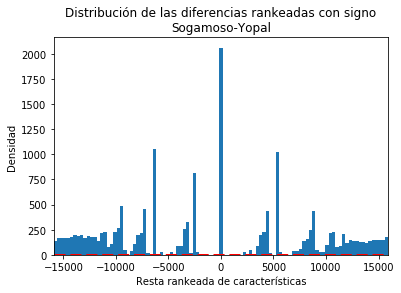

In [9]:
#graph_wilcox(ORIGEN, "Manizales", "Pereira", small=True)
#graph_hist(ORIGEN, "Valencia", "Tierralta", small=False, barras=101)
graph_rankedhist(ORIGEN, "Sogamoso", "Yopal", small=False, barras=101)

wilcoxon:-2808480.0
t1:2750223.0  t2:5558703.0
tmio:2750223.0  tsoft:2750223.0
rancorr:-0.3380075836516055
z:18.689633977210015 p:6.012396406816495e-78



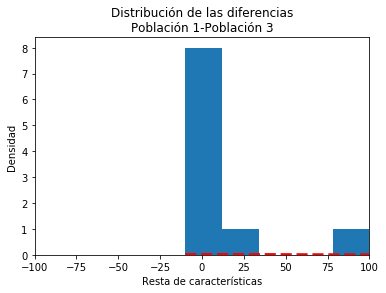

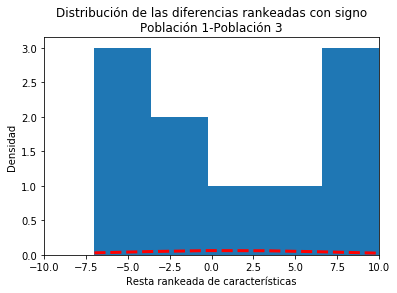

In [10]:
#graph_wilcox(datos_prueba,   "Población 1", "Población 3", dotsize=30, small=False, labelpoints=True)
graph_hist(datos_prueba,   "Población 1", "Población 3", small=False, barras=5)
graph_rankedhist(datos_prueba,   "Población 1", "Población 3", small=False, barras=5)

In [11]:
def graph_ZIPF(origin, city1, city2, small=True, labelpoints=False,dotsize=1):
    
    if small == True:
        city1_len,city2_len,proportion,dialects = smallest_vocabulary(origin, city1, city2)
    else:
        dialects = origin[[city1, city2]]
    
    plt.close('all')
    
    
    # Grafica de distribución ZIPF
    dialectA = dialects[city1]*10e7
    dialectB = dialects[city2]*10e7
    ranka = dialectA.rank(method="average", ascending=False)
    rankb = dialectB.rank(method="average", ascending=False)
    substraction = (ranka-rankb)
    sign = np.sign(substraction)
    x = np.array(range(1,ranka.shape[0]+1))
    x2 = np.array(x*sign)
    plt.clf
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(ranka, x, c="blue", s=dotsize, edgecolors='none', label=city1)
    ax.scatter(rankb, -x, c="red", s=dotsize, edgecolors='none', label=city2)
    ax.scatter (x,substraction ,c="green", s=dotsize*3, edgecolors='none', label="Resta")
    ax.set_ylabel('Rank')
    ax.set_xlabel('Características')
    ax.set_title('\n Distribución de valores pareados \n {} ({} palabras)  / {} ({} palabras) \n Proporción: {}'.format(city1, city1_len, city2, city2_len,round(proportion, 2)))
    ax.legend(markerscale=2, loc='upper left', fontsize=12 )
    ax.grid(True)
    ax.autoscale(enable=True, axis='both', tight=True)
    if labelpoints==True:
        labelpos = list(dialectA.index.values)
        labelcero = list([' '])
        labels = labelcero+labelpos
        tickposition = np.array(range(0,x.max()+1))
        ax.set_yticks(tickposition)
        ax.set_yticklabels(labels, fontsize=12)
    plt.tight_layout()
    plt.savefig('/src/data/procesados/graphics/divergencia/distribucion_{}-{}.pdf'.format(city1.replace(' ', ''), city2.replace(' ', '')))
    

<IPython.core.display.Javascript object>


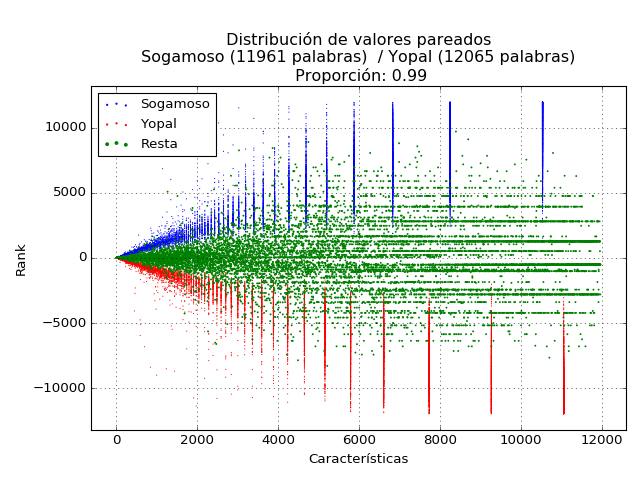

In [77]:
graph_ZIPF(ORIGEN, "Sogamoso", "Yopal", small=True)

In [57]:
def graph_ZIPF2(origin, city1, city2, small=True, labelpoints=False,dotsize=1):

    if small == True:
        city1_len,city2_len,proportion,dialects = smallest_vocabulary(origin, city1, city2)
    else:
        dialects = origin[[city1, city2]]
    
    plt.close('all')    
    
    T, pvalue = wilcoxon(dialects[city1],dialects[city2])
    resta = (dialects[city1]-dialects[city2])
    resta = resta.loc[resta != 0]
    n = resta.shape[0]
    s = n*(n+1)/2
    sign = np.sign(resta)
    rank = (abs(resta)).rank(method="average")
    signedrank = sign*rank
    wilcox = signedrank.sum()
 
    if n == 0:
        rankcorr = n
        x = np.array([0,0])
        signedrank = np.array([0,0])
        t1 = np.array([0,0])
        t2 = np.array([0,0])
        t=0
        z=0
    else:
        rankcorr = wilcox/s
        t1 = abs(signedrank.loc[signedrank > 0].sum())
        t2 = abs(signedrank.loc[signedrank < 0].sum())
        t = min(t1,t2)
        z = abs(t-(n*(n+1)/4))/(n*(n+1)*(2*n+1)/(24))**(1/2)
        x = np.array(range(0,n))
        
    plt.clf
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(signedrank, x , c="green", s=dotsize, edgecolors='none', label="Resta")
    rectangle = plt.Rectangle((-rankcorr, 0), 2*rankcorr, x.max(), fc='r')
    ax.add_patch(rectangle)
    ax.legend(loc='lower left')
    ax.set_xlabel('Rango con signos')
    ax.set_ylabel('Características')
    ax.set_title('Distribución de restas rankeadas con signo  \n{}-{}'.format(city1, city2))
    if labelpoints==True:
        labelpos = list(dialectA.index.values)
        labelcero = list([' '])
        labels = labelpos
        tickposition = np.array(range(0,x.max()+1))
        ax.set_yticks(tickposition)
        ax.set_yticklabels(labels, fontsize=12)
    #ax.set_yscale('log')
    ax.set_xscale('symlog')
    ax.annotate('Correlación de ranking:\n{}'.format(abs(round(rankcorr,3))), xy=(0, x.max()), xytext=(0, x.max()+100), ha='center')

    plt.savefig('/src/data/procesados/graphics/wilcoxon/wilcoxon_{}-{}.pdf'.format(city1.replace(' ', ''), city2.replace(' ', '')))


<IPython.core.display.Javascript object>


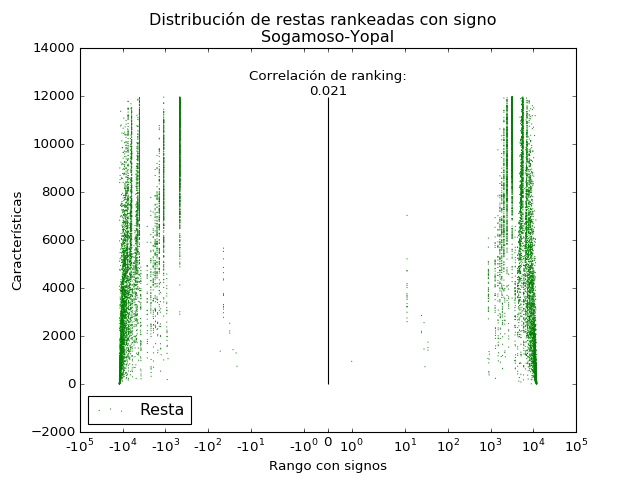

In [79]:
graph_ZIPF2(ORIGEN, "Sogamoso", "Yopal", small=True)